<a href="https://colab.research.google.com/github/ogonna-anaekwe/text_classifier/blob/master/Text_Classification_with_Movie_Reviews_(Data_Eng_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text Classifier - V1

In [2]:
# import dependencies
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print(f'Version: {tf.__version__}')
print(f'Eager mode: {tf.executing_eagerly()}')
print(f'Hub version: {hub.__version__}')
print(f'GPU is {"available" if tf.config.list_physical_devices("GPU") else "not available"}')

Version: 2.4.1
Eager mode: True
Hub version: 0.11.0
GPU is available


In [3]:
# this example uses the imdb reviews dataset
# load the dataset
train_data, test_data = tfds.load(name="imdb_reviews", 
                                  split=["train", "test"],
                                  batch_size=-1, 
                                  as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0I8NU6/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0I8NU6/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0I8NU6/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# neural networks works with tensors
# convert the dataset python generator yielding 1D tensors

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

print(f'shape of train_examples {train_examples.shape}')
print(f'shape of train_labels {train_labels.shape}')
print(f'shape of test_examples {test_examples.shape}')
print(f'shape of test_labels {test_labels.shape}')

shape of train_examples (25000,)
shape of train_labels (25000,)
shape of test_examples (25000,)
shape of test_labels (25000,)


In [5]:
# show first 5 reviews
train_examples[:5]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

In [6]:
# show first 5 labels corresponding to the reviews above
train_labels[:5]

array([0, 0, 0, 1, 1])

In [11]:
# the reviews byte encoded, and not strings
# the pretrained model that we'll use decodes the reviews
# it also handles tokenization of each review and
# it converts each review a 50D word vector/embedding
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

# confirm that each review is mapped to 50D word embedding
def confirm_dim(features=train_examples):
  """
  Confirms the word embedding for each review is 50D
  
  Parameters:
    all_examples_features: feature space showing all reviews
  
  Returns:
    Whether or not the reviews are mapped to 50D word embeddings
  """
  is_50d = [True for review in hub_layer(features) if review.shape[0] == 50]
  if False in is_50d:
    return f'At least one review is not mapped to a 50D word embedding'
  return f'Each review is mapped to a 50D word embedding'

print(f'{confirm_dim(train_examples)}')
print(f'{confirm_dim(test_examples)}')

Each review is mapped to a 50D word embedding
Each review is mapped to a 50D word embedding


In [12]:
# to create model architecture, stack layers using the keras Sequential class 
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# show model architecture
model.summary()

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x7f12f2b72680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/tracking.py", line 208, in __del__
    self._destroy_resource()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 726, in _initialize
    *args, **kwds))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/p

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [13]:
# define model loss and optimizer as well as metrics to monitor during training
model.compile(optimizer='adam',
               loss=tf.losses.BinaryCrossentropy(from_logits=True),
               metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [14]:
# slice data to create train and validation sets
# we'll train the model on the train set, and use the validation set for validation
# this helps us monitor the model for potential overfitting and
# if the model generalizes to unseen data
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [15]:
# train model
# model metrics (i.e. loss, accuracy) will be stored in this variable
batch_size = 512
epochs = 10
history = model.fit(partial_x_train, partial_y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 4s 81ms/step - loss: 0.6969 - accuracy: 0.5480 - val_loss: 0.6435 - val_accuracy: 0.6966
Epoch 2/10
30/30 [==============================] - 2s 78ms/step - loss: 0.6188 - accuracy: 0.7387 - val_loss: 0.5529 - val_accuracy: 0.7730
Epoch 3/10
30/30 [==============================] - 2s 76ms/step - loss: 0.5044 - accuracy: 0.8148 - val_loss: 0.4377 - val_accuracy: 0.8314
Epoch 4/10
30/30 [==============================] - 2s 76ms/step - loss: 0.3636 - accuracy: 0.8801 - val_loss: 0.3582 - val_accuracy: 0.8577
Epoch 5/10
30/30 [==============================] - 2s 78ms/step - loss: 0.2584 - accuracy: 0.9183 - val_loss: 0.3198 - val_accuracy: 0.8686
Epoch 6/10
30/30 [==============================] - 2s 78ms/step - loss: 0.1892 - accuracy: 0.9422 - val_loss: 0.3012 - val_accuracy: 0.8753
Epoch 7/10
30/30 [==============================] - 2s 78ms/step - loss: 0.1387 - accuracy: 0.9624 - val_loss: 0.2981 - val_accuracy: 0.8772
Epoch 8/10
30

In [18]:
# evaluate model performance on test data
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f'test loss: {round(test_loss * 100, 2)}%')
print(f'test acc: {round(test_acc * 100, 2)}%')

782/782 [==============================] - 4s 5ms/step - loss: 0.3491 - accuracy: 0.8605
test loss: 34.91%
test acc: 86.05%


In [19]:
# get keys for the model's metrics
# shows the trend of loss and accuracy (and generally, potential overfitting)
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
def plot_metrics(metric='accuracy'):
  """
  Helper function to plot the metrics of the model
    Parameter:
      metric: the metric that we seek to plot ex. accuracy, acc, loss

    Returns:
      plot of the trend of the metrics over the epochs
  """
  if metric in ['accuracy', 'acc', 'loss']:
    metric_one = history_dict[f'{metric}']
    metric_two = history_dict[f'val_{metric}']
    epochs = range(1, len(metric_one) + 1)
  
    plt.clf()
    # "bo" is for "blue dot"  
    plt.plot(epochs, metric_one, 'bo', label=f'training {metric}')
    # b is for "solid blue line"
    plt.plot(epochs, metric_two, 'b', label=f'validation {metric}')
    plt.title(f'training and talidation {metric}')
    plt.xlabel('epochs')
    plt.ylabel(f'{metric}')
    plt.legend()
    plt.show()

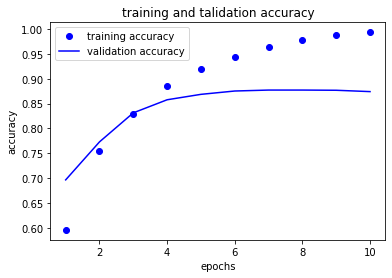

In [23]:
# plot model accuracy over epochs
plot_metrics(metric='accuracy')

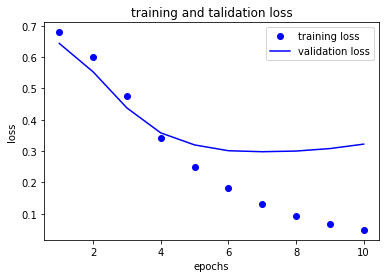

In [24]:
# plot model loss over epochs
plot_metrics(metric='loss')

In [25]:
# saving the model version.
model_name = 'text_classifier'
version = '1'
file_path = f'./{model_name}/{version}'
tf.keras.models.save_model(
    model,
    file_path,
    overwrite=True,
    include_optimizer=True,
    save_format='tf')


INFO:tensorflow:Assets written to: ./text_classifier/1/assets


INFO:tensorflow:Assets written to: ./text_classifier/1/assets


Text Classifier - V2

In [26]:
# import dependencies
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print(f'Version: {tf.__version__}')
print(f'Eager mode: {tf.executing_eagerly()}')
print(f'Hub version: {hub.__version__}')
print(f'GPU is {"available" if tf.config.list_physical_devices("GPU") else "not available"}')

Version: 2.4.1
Eager mode: True
Hub version: 0.11.0
GPU is available


In [27]:
# this example uses the imdb reviews dataset
# load the dataset
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"],
                                  batch_size=-1, as_supervised=True)


In [28]:
# neural networks works with tensors
# convert the dataset python generator yielding 1D tensors

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

print(f'shape of train_examples {train_examples.shape}')
print(f'shape of train_labels {train_labels.shape}')
print(f'shape of test_examples {test_examples.shape}')
print(f'shape of test_labels {test_labels.shape}')

shape of train_examples (25000,)
shape of train_labels (25000,)
shape of test_examples (25000,)
shape of test_labels (25000,)


In [29]:
# concatenate train and test examples and labels
def concatenate_data(train_features=train_examples, test_features=test_examples, train_labels=train_labels, test_labels=test_labels):
  """
  Returns all train and test features in one array and all train and test labels in another array.

  Parameters:
    train_features: 1D tensor of train features
    test_features: 1D tensor of test features
    train_labels: 1D tensor of train labels
    test_labels: 1D tensor of test labels
  
  Returns:
    all_examples_features: 1D tensor of train and test features concatenated
    all_examples_labels: 1D tensor of train and test labels concatenated
  """

  try:
    assert train_examples.shape == test_examples.shape, \
    f'Tensor shapes do not match. The shape of your first tensor is {train_examples.shape} and the shape of your second tensor is {test_examples.shape}.'

    assert train_labels.shape == test_labels.shape, \
    f'Tensor shapes do not match. The shape of your first tensor is {train_labels.shape} and the shape of your second tensor is {test_labels.shape}.'

    all_examples_features = np.concatenate((train_examples, test_examples), axis=0)
    all_examples_labels = np.concatenate((train_labels, test_labels), axis=0)
    return all_examples_features, all_examples_labels
  except AssertionError as msg:
    print(msg)

all_examples_features, all_examples_labels = concatenate_data(train_features=train_examples, test_features=test_examples, train_labels=train_labels, test_labels=test_labels)

In [30]:
print(f'shape of features after concatenation {all_examples_features.shape}')
print(f'shape of labels after concatenation {all_examples_labels.shape}')

shape of features after concatenation (50000,)
shape of labels after concatenation (50000,)


In [52]:
range(len(train_examples), len(all_examples_features))

range(25000, 50000)

In [63]:
# helper function to check that the original data was combined correctly
# def (train_examples=train_examples, tes)
def data_match(all_examples_features=all_examples_features, all_examples_labels=all_examples_labels, train_examples=train_examples, train_labels=train_labels, test_examples=test_examples, test_labels=test_labels):
  len_all_example_features = len(all_examples_features)
  len_all_examples_labels = len(all_examples_labels)
  len_train_examples = len(train_examples)
  len_train_labels = len(train_labels)
  
  features_match_train = [True for idx in range(0, len_all_example_features)[:len_train_examples] if train_examples[idx] == all_examples_features[idx]]
  features_match_test = [True for idx in range(len_train_examples, len_all_example_features)[len_train_examples:] if test_examples[idx] == all_examples_features[idx]]
  labels_match_train = [True for idx in range(0, len_all_examples_labels)[:len_train_labels] if train_labels[idx] == all_examples_labels[idx]]
  labels_match_test = [True for idx in range(len_train_examples, len_all_examples_labels)[len_train_labels:] if test_labels[idx] == all_examples_labels[idx]]

  if False in [features_match_train, features_match_test]:
    return f'Mismatch detected in features'
  
  if False in [labels_match_train, labels_match_test]:
    return f'Mismatch detected in labels'
  
  return f'All features and labels match'
  
data_match(all_examples_features=all_examples_features, train_examples=train_examples, test_examples=test_examples)

'All features and labels match'

In [65]:
# the reviews are not actually strings. they are byte encoded
# however, the pretrained model that we'll use handles the decoding
# it also handles tokenization of each review and
# it converts each timestep in the sequence of words to a 50D word vector/embedding
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

def confirm_dim(features=all_examples_features):
  """
  Confirms the word embedding for each review is 50D
  
  Parameters:
    all_examples_features: feature space showing all reviews
  
  Returns:
    Whether or not the reviews are mapped to 50D word embeddings
  """
  is_50d = [True for review in hub_layer(all_examples_features) if review.shape[0] == 50]
  if False in is_50d:
    return f'At least one review is not mapped to a 50D word embedding'
  return f'Each review is mapped to a 50D word embedding'

confirm_dim(all_examples_features)

'Each review is mapped to a 50D word embedding'

In [66]:
# stack layers using the keras Sequential class to create network architecture
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# show model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_2 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [67]:
# define model loss and optimizer 
# as well as metrics to monitor during training
model.compile(optimizer='adam',
               loss=tf.losses.BinaryCrossentropy(from_logits=True),
               metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [69]:
# slice data to create train and validation sets
# we'll train the model on the train set, and use the validation set for validation
# this helps us monitor the model for potential overfitting and most importantly
# if the model generalizes to unseen data
def train_test_split(split_pct=0.3, features=all_examples_features, labels=all_examples_labels):
  """
  Splits aggregate data into train and test sets based.

  Parameters:
    split_pct: percent of the aggregate data placed in the test set
    features: 1D tensor of all features. Features here represent reviews
    labels: 1D tensor of all labels. Labels here represent the sentiment of the review: 0 or 1
  
  Returns:
    train_features: 1D tensor of features in the train set
    train_labels: 1D tensor of labels in the train set
    test_features: 1D tensor of features in the test set
    test_labels: 1D tensor of labels in the test set
  """
  data_dimension = all_examples_features.shape[0]
  data_slice = int(round(data_dimension * split_pct))
  train_features = all_examples_features[:data_dimension - data_slice]
  train_labels = all_examples_labels[:data_dimension - data_slice]
  test_features = all_examples_features[data_dimension - data_slice:]
  test_labels = all_examples_labels[data_dimension - data_slice:]
  return train_features, train_labels, test_features, test_labels

train_features, train_labels, test_features, test_labels = train_test_split(split_pct=0.3, features=all_examples_features, labels=all_examples_labels)

print(f'shape of train features {train_features.shape}')
print(f'shape of train labels {train_labels.shape}')
print(f'shape of test features {test_features.shape}')
print(f'shape of test labels {test_labels.shape}')




shape of train features (35000,)
shape of train labels (35000,)
shape of test features (15000,)
shape of test labels (15000,)


In [70]:
# train model
# model metrics (i.e. loss, accuracy) will be stored in this variable
batch_size = 512
validation_split = 0.3
epochs = 10
history = model.fit(train_features, train_labels,
                    epochs=epochs, batch_size=batch_size,
                    validation_split=validation_split,
                    verbose=1)

Epoch 1/10
48/48 [==============================] - 4s 72ms/step - loss: 0.6532 - accuracy: 0.6270 - val_loss: 0.5292 - val_accuracy: 0.7759
Epoch 2/10
48/48 [==============================] - 3s 66ms/step - loss: 0.4656 - accuracy: 0.8212 - val_loss: 0.3875 - val_accuracy: 0.8405
Epoch 3/10
48/48 [==============================] - 3s 68ms/step - loss: 0.2986 - accuracy: 0.8960 - val_loss: 0.3304 - val_accuracy: 0.8584
Epoch 4/10
48/48 [==============================] - 3s 67ms/step - loss: 0.2142 - accuracy: 0.9293 - val_loss: 0.3044 - val_accuracy: 0.8701
Epoch 5/10
48/48 [==============================] - 3s 66ms/step - loss: 0.1478 - accuracy: 0.9576 - val_loss: 0.3024 - val_accuracy: 0.8727
Epoch 6/10
48/48 [==============================] - 3s 67ms/step - loss: 0.1066 - accuracy: 0.9725 - val_loss: 0.3147 - val_accuracy: 0.8710
Epoch 7/10
48/48 [==============================] - 3s 67ms/step - loss: 0.0746 - accuracy: 0.9835 - val_loss: 0.3301 - val_accuracy: 0.8690
Epoch 8/10
48

In [71]:
# evaluate model performance on test data
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f'test_loss: {round(test_loss * 100, 2)}%')
print(f'test_acc: {round(test_acc * 100, 2)}%')

469/469 [==============================] - 2s 5ms/step - loss: 0.4029 - accuracy: 0.8589
test_loss: 40.29%
test_acc: 85.89%


In [84]:
print(model.predict([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."]))
print(model.predict([b'As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very ably shows the hypocrisy of the female libido. When men are around they want to be pursued, but when no "men" are around, they become the pursuers of a 14 year old boy. And the boy becomes a man really fast (we should all be so lucky at this age!). He then gets up the courage to pursue his true love']))

[[-9.223995]]
[[2.7818885]]


In [76]:
# get keys for the model's metrics
# needed to eventually see the trend of loss and accuracy (and generally, potential overfitting)
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [77]:
def plot_metrics(metric='accuracy'):
  """
  Helper function to plot the metrics of the model
    Parameter:
      metric: the metric that we seek to plot ex. accuracy, acc, loss

    Returns:
      plot of the trend of the metrics over the epochs
  """
  if metric in ['accuracy', 'acc', 'loss']:
    metric_one = history_dict[f'{metric}']
    metric_two = history_dict[f'val_{metric}']
    epochs = range(1, len(metric_one) + 1)
  
    plt.clf()
    # "bo" is for "blue dot"  
    plt.plot(epochs, metric_one, 'bo', label=f'training {metric}')
    # b is for "solid blue line"
    plt.plot(epochs, metric_two, 'b', label=f'validation {metric}')
    plt.title(f'training and talidation {metric}')
    plt.xlabel('epochs')
    plt.ylabel(f'{metric}')
    plt.legend()
    plt.show()

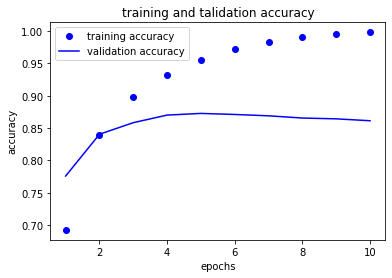

In [78]:
# plot model accuracy over epochs
plot_metrics(metric='accuracy')

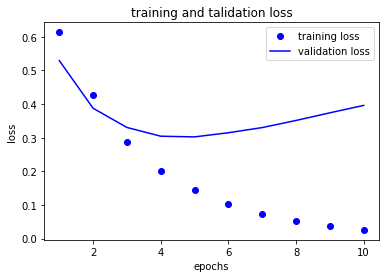

In [79]:
# plot model loss over epochs
plot_metrics(metric='loss')

In [80]:
# saving the model version.
model_name = 'text_classifier'
version = '2'
file_path = f'./{model_name}/{version}'
tf.keras.models.save_model(
    model,
    file_path,
    overwrite=True,
    include_optimizer=True,
    save_format='tf')


INFO:tensorflow:Assets written to: ./text_classifier/2/assets


INFO:tensorflow:Assets written to: ./text_classifier/2/assets


In [83]:
# zip saved model and download to the downloads folder of your local machine
!zip -r /content/text_classifier.zip /content/text_classifier

# download files to the downloads folder of your local machine
from google.colab import files
files.download('/content/text_classifier.zip')


  adding: content/text_classifier/ (stored 0%)
  adding: content/text_classifier/2/ (stored 0%)
  adding: content/text_classifier/2/variables/ (stored 0%)
  adding: content/text_classifier/2/variables/variables.index (deflated 60%)
  adding: content/text_classifier/2/variables/variables.data-00000-of-00001 (deflated 64%)
  adding: content/text_classifier/2/saved_model.pb (deflated 86%)
  adding: content/text_classifier/2/assets/ (stored 0%)
  adding: content/text_classifier/2/assets/tokens.txt (deflated 47%)
  adding: content/text_classifier/1/ (stored 0%)
  adding: content/text_classifier/1/variables/ (stored 0%)
  adding: content/text_classifier/1/variables/variables.index (deflated 60%)
  adding: content/text_classifier/1/variables/variables.data-00000-of-00001 (deflated 65%)
  adding: content/text_classifier/1/saved_model.pb (deflated 85%)
  adding: content/text_classifier/1/assets/ (stored 0%)
  adding: content/text_classifier/1/assets/tokens.txt (deflated 47%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
docker run -p 8501:8501 --name tfserving_classifier \
--mount type=bind,source=/Users/ogonnaanaekwe/Downloads/content/text_classifier,target=/models/text_classifier \
-e MODEL_NAME=text_classifier -t tensorflow/serving


curl -d '{"instances": ["this is terrible", "this is great"]}' \
    -X POST http://localhost:8501/v1/models/text_classifier:predict